In [1]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:800px;  /* your desired max-height here */
    overflow: auto;
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn import preprocessing
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
import re

In [3]:
html_tags = ["a",
"abbr",
"acronym",
"address",
"applet",
"area",
"article",
"aside",
"audio",
"b",
"base",
"basefont",
"bdi",
"bdo",
"bgsound",
"big",
"blink",
"blockquote",
"body",
"br",
"button",
"canvas",
"caption",
"center",
"cite",
"code",
"col",
"colgroup",
"content",
"data",
"datalist",
"dd",
"decorator",
"del",
"details",
"dfn",
"dir",
"div",
"dl",
"dt",
"element",
"em",
"embed",
"fieldset",
"figcaption",
"figure",
"font",
"footer",
"form",
"frame",
"frameset",
"h1",
"h2",
"h3",
"h4",
"h5",
"h6",
"head",
"header",
"hgroup",
"hr",
"html",
"i",
"iframe",
"img",
"input",
"ins",
"isindex",
"kbd",
"keygen",
"label",
"legend",
"li",
"link",
"listing",
"main",
"map",
"mark",
"marquee",
"menu",
"menuitem",
"meta",
"meter",
"nav",
"nobr",
"noframes",
"noscript",
"object",
"ol",
"optgroup",
"option",
"output",
"p",
"param",
"plaintext",
"pre",
"progress",
"q",
"rp",
"rt",
"ruby",
"s",
"samp",
"script",
"section",
"select",
"shadow",
"small",
"source",
"spacer",
"span",
"strike",
"strong",
"style",
"sub",
"summary",
"sup",
"table",
"tbody",
"td",
"template",
"textarea",
"tfoot",
"th",
"thead",
"time",
"title",
"tr",
"track",
"tt",
"u",
"ul",
"var",
"video",
"wbr",
"xmp"];

In [4]:
le = preprocessing.LabelEncoder()
df = pd.concat(map(pd.read_csv, ['input_warn.csv', 'input_error.csv', 'input_exhaustion.csv', 'input_info.csv']))
df = df.sample(frac=1).reset_index(drop=True)

In [5]:
df = df.fillna('')

In [6]:
df = df.drop(['hits/_index', 'hits/_type', 'hits/_id', 'hits/_score'], axis=1)

In [7]:
df.dtypes

hits/_source/$event/app          object
hits/_source/$event/exception    object
hits/_source/$event/level        object
hits/_source/$event/message      object
hits/_source/$event/timestamp    object
dtype: object

In [8]:
df['hits/_source/$event/timestamp'] = pd.to_datetime(df['hits/_source/$event/timestamp'])
df['hits/_source/$event/level'] = le.fit_transform(df['hits/_source/$event/level'])

In [9]:
df.head()

,hits/_source/$event/app,hits/_source/$event/exception,hits/_source/$event/level,hits/_source/$event/message,hits/_source/$event/timestamp
0,Exchange Rate Service,,1,The closest date for 04/19/2022 00:47:34 is da...,2022-04-19 00:47:34.758000+00:00
1,Templates Service,,0,TemplateFetchError: Template corresponding to ...,2022-04-19 09:04:56.977000+00:00
2,Exchange Rate Service,,1,The closest date for 04/19/2022 00:46:40 is da...,2022-04-19 00:46:40.714000+00:00
3,Orders Service,,0,"Numfailed attempts: 1, amountToCapture: 71.2, ...",2022-04-19 09:07:13.510000+00:00
4,Cms Service,,2,"Slow response detected from ""http://cms.gogift...",2022-04-19 00:53:40.982000+00:00


In [10]:
stemmer = PorterStemmer()
def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [porter_stemmer.stem(word) for word in words]
    return words

In [11]:
def tokenize(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation, html tags)
    for token in tokens:
        if re.search('^[a-zA-Z]+$', token) and not token in html_tags:
            filtered_tokens.append(token)
    return filtered_tokens

In [12]:
data = df['hits/_source/$event/message']
types = df['hits/_source/$event/level']


tf_idf_vectorizer = TfidfVectorizer(stop_words = 'english', tokenizer = tokenize, lowercase=False,
                             max_features = 20000)
tf_idf = tf_idf_vectorizer.fit_transform(data)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

In [13]:
sklearn_pca = PCA(n_components = 28)
y_sklearn = sklearn_pca.fit_transform(tf_idf_array)

print(y_sklearn)

# Trying out OPTICS
# Building the OPTICS Clustering model
optics_model = OPTICS(min_samples = 10, xi = 0.05, min_cluster_size = 0.05)
  
# Training the model
optics_model.fit(y_sklearn)

[[ 7.67664534e-01  2.30773207e-01  4.54794897e-02 ... -1.61100784e-05
  -4.26335929e-04 -5.31477300e-04]
 [-1.01715277e-01 -1.72996607e-01 -9.61823654e-02 ... -2.02009302e-03
  -2.46056668e-02 -2.50361412e-02]
 [ 7.67664534e-01  2.30773207e-01  4.54794897e-02 ... -1.61100784e-05
  -4.26335929e-04 -5.31477300e-04]
 ...
 [ 7.67664534e-01  2.30773207e-01  4.54794897e-02 ... -1.61100784e-05
  -4.26335929e-04 -5.31477300e-04]
 [-1.19229192e-01 -2.26433558e-01 -1.79287972e-01 ... -2.67941341e-01
   2.02360877e-02  1.52058722e-02]
 [-9.88843860e-02 -1.65623329e-01 -8.90402213e-02 ... -2.81363032e-02
  -2.74406865e-02  6.03857328e-02]]


C:\Users\dnfmge\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\cluster\_optics.py:903: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


OPTICS(min_cluster_size=0.05, min_samples=10)

In [14]:
# Producing the labels according to the DBSCAN technique with eps = 0.5
labels1 = cluster_optics_dbscan(reachability = optics_model.reachability_,
                                   core_distances = optics_model.core_distances_,
                                   ordering = optics_model.ordering_, eps = 0.5)
  
# Producing the labels according to the DBSCAN technique with eps = 2.0
labels2 = cluster_optics_dbscan(reachability = optics_model.reachability_,
                                   core_distances = optics_model.core_distances_,
                                   ordering = optics_model.ordering_, eps = 2)
  
# Creating a numpy array with numbers at equal spaces till
# the specified range
space = np.arange(len(y_sklearn))
  
# Storing the reachability distance of each point
reachability = optics_model.reachability_[optics_model.ordering_]
  
# Storing the cluster labels of each point
labels = optics_model.labels_[optics_model.ordering_]
  
print(labels)

[0 0 0 ... 4 4 4]


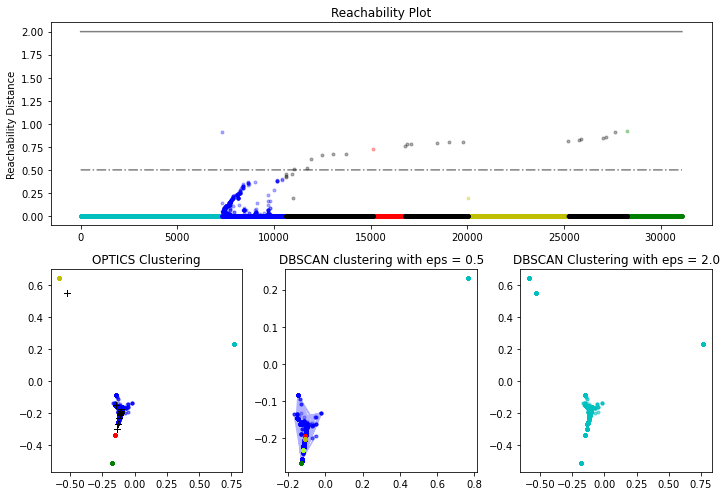

In [15]:
plt.figure(figsize =(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])
  
# Plotting the Reachability-Distance Plot
colors = ['c.', 'b.', 'r.', 'y.', 'g.']
for Class, colour in zip(range(0, 5), colors):
    Xk = space[labels == Class]
    Rk = reachability[labels == Class]
    ax1.plot(Xk, Rk, colour, alpha = 0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha = 0.3)
ax1.plot(space, np.full_like(space, 2., dtype = float), 'k-', alpha = 0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype = float), 'k-.', alpha = 0.5)
ax1.set_ylabel('Reachability Distance')
ax1.set_title('Reachability Plot')
  
# Plotting the OPTICS Clustering
colors = ['c.', 'b.', 'r.', 'y.', 'g.']
for Class, colour in zip(range(0, 5), colors):
    Xk = y_sklearn[optics_model.labels_ == Class]
    ax2.plot(Xk[:, 0], Xk[:, 1], colour, alpha = 0.3)
      
ax2.plot(y_sklearn[optics_model.labels_ == -1, 0],
        y_sklearn[optics_model.labels_ == -1, 1],
       'k+', alpha = 0.1)
ax2.set_title('OPTICS Clustering')
  
# Plotting the DBSCAN Clustering with eps = 0.5
colors = ['c', 'b', 'r', 'y', 'g', 'greenyellow']
for Class, colour in zip(range(0, 6), colors):
    Xk = y_sklearn[labels1 == Class]
    ax3.plot(Xk[:, 0], Xk[:, 1], colour, alpha = 0.3, marker ='.')
        
ax3.plot(y_sklearn[labels1 == -1, 0],
        y_sklearn[labels1 == -1, 1],
       'k+', alpha = 0.1)
ax3.set_title('DBSCAN clustering with eps = 0.5')
  
# Plotting the DBSCAN Clustering with eps = 2.0
colors = ['c.', 'y.', 'm.', 'g.']
for Class, colour in zip(range(0, 4), colors):
    Xk = y_sklearn[labels2 == Class]
    ax4.plot(Xk[:, 0], Xk[:, 1], colour, alpha = 0.3)
          
ax4.plot(y_sklearn[labels2 == -1, 0],
        y_sklearn[labels2 == -1, 1],
       'k+', alpha = 0.1)
ax4.set_title('DBSCAN Clustering with eps = 2.0')
  
  
plt.tight_layout()
plt.show()

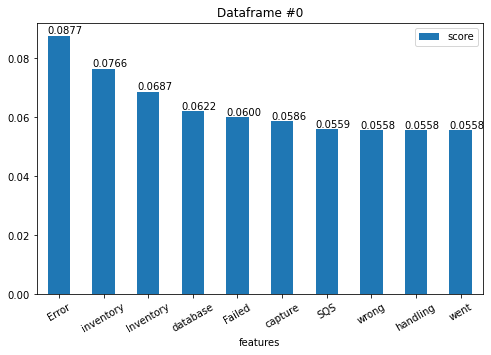

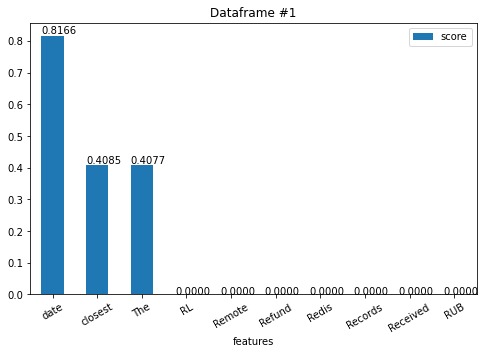

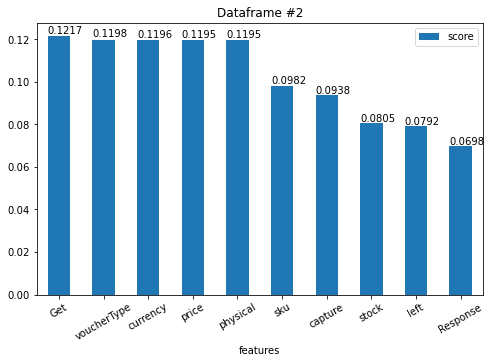

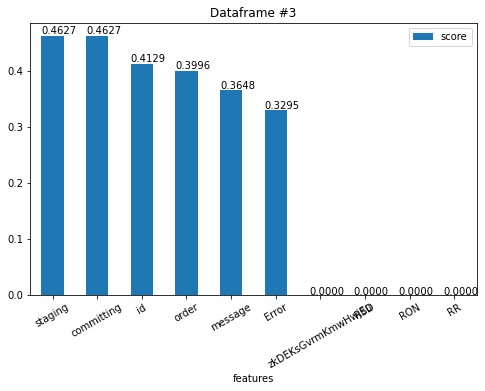

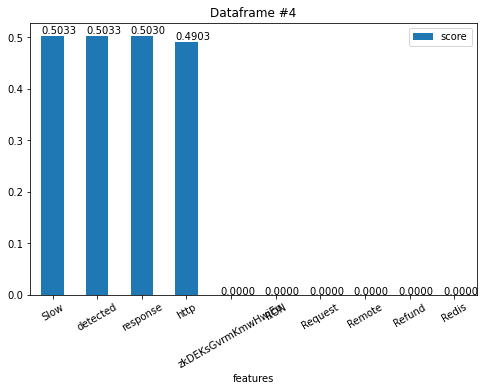

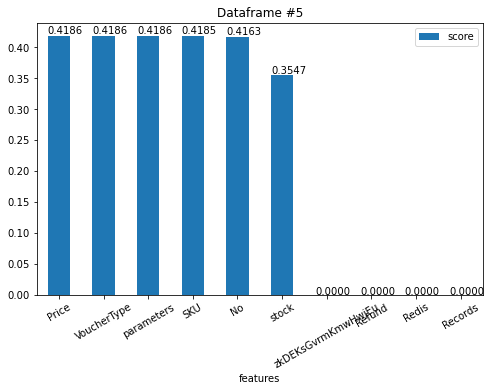

In [16]:
def get_top_features_cluster(tf_idf_array, n_feats):
    labels = np.unique(optics_model.labels_)
    dfs = []
    for label in labels:
        id_temp = np.where(optics_model.labels_==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizer.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_array, 10)

for num, dataframe in enumerate(dfs):
    ax = dataframe.plot.bar(x='features', y='score', figsize=(8,5))
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.4f}', xy=(p.get_x(), p.get_height() * 1.01))
    ax.tick_params(axis='x', labelrotation=30)
    
    ax.set_title(f'Dataframe #{num}')
    plt.show()


In [17]:
# Defining other algorithms for the sake of testing
''' One-class SVM '''
def model_ocSVM(data):
    from sklearn.svm import OneClassSVM
    
    ocSVM = OneClassSVM(kernel="rbf")
    y_pred = ocSVM.fit_predict(data)
    
    return y_pred

''' Isolation Forest '''
def model_iF(data):
    from sklearn.ensemble import IsolationForest
    
    iF = IsolationForest(random_state=0)
    y_pred = iF.fit_predict(data)
    
    return y_pred

''' Local Outlier Factor '''
def model_LOF(data):
    from sklearn.neighbors import LocalOutlierFactor
    
    lof = LocalOutlierFactor(metric = 'hamming')
    y_pred = lof.fit_predict(data)
    
    return y_pred

''' K-Means Machine Learning Model '''
def model_KMeans(data):
    from sklearn.cluster import KMeans
    
    kmeans = KMeans(n_clusters = 2, init = 'k-means++', algorithm = 'full', random_state = 42)
    y_pred = kmeans.fit_predict(data)
    
    return y_pred

''' Hierarchical Clustering '''
def model_HC(data):
    from sklearn.cluster import AgglomerativeClustering
    
    hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
    y_pred = hc.fit_predict(data)
    
    return y_pred

In [18]:
models = models = {"ocSVM":  model_ocSVM, "iF": model_iF, "LOF": model_LOF, 
           "K-Means": model_KMeans, "HC": model_HC}

In [19]:
for model_name in models:
    model = models[model_name]
    print(type(y_sklearn))
    y_pred = model(y_sklearn)
    df[model_name] = y_pred
    print(y_pred)

<class 'numpy.ndarray'>
[-1 -1 -1 ... -1 -1  1]
<class 'numpy.ndarray'>
[ 1  1  1 ...  1 -1  1]
<class 'numpy.ndarray'>
[-1 -1 -1 ... -1  1 -1]
<class 'numpy.ndarray'>
[1 0 1 ... 1 0 0]
<class 'numpy.ndarray'>
[1 0 1 ... 1 0 0]


In [20]:
for model_name in models:
    if model_name == "ocSVM" or "iF":
        for i, row in enumerate(df[model_name]):
            if df[model_name][i] == 1:
                df[model_name][i] = 0
            else:
                df[model_name][i] = 1

C:\Users\dnfmge\AppData\Local\Temp\ipykernel_34320\3832755004.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[model_name][i] = 1
C:\Users\dnfmge\AppData\Local\Temp\ipykernel_34320\3832755004.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[model_name][i] = 0


In [21]:
df.head(300)

,hits/_source/$event/app,hits/_source/$event/exception,hits/_source/$event/level,hits/_source/$event/message,hits/_source/$event/timestamp,ocSVM,iF,LOF,K-Means,HC
0,Exchange Rate Service,,1,The closest date for 04/19/2022 00:47:34 is da...,2022-04-19 00:47:34.758000+00:00,1,0,1,0,0
1,Templates Service,,0,TemplateFetchError: Template corresponding to ...,2022-04-19 09:04:56.977000+00:00,1,0,1,1,1
2,Exchange Rate Service,,1,The closest date for 04/19/2022 00:46:40 is da...,2022-04-19 00:46:40.714000+00:00,1,0,1,0,0
3,Orders Service,,0,"Numfailed attempts: 1, amountToCapture: 71.2, ...",2022-04-19 09:07:13.510000+00:00,1,1,1,1,1
4,Cms Service,,2,"Slow response detected from ""http://cms.gogift...",2022-04-19 00:53:40.982000+00:00,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
295,ProductsAggregatorService,Npgsql.PostgresException (0x80004005): 42P10: ...,0,10 state change attempt(s) failed due to an ex...,2022-04-19 10:54:22.273000+00:00,0,0,0,1,1
296,Exchange Rate Service,,1,The closest date for 04/19/2022 00:48:06 is da...,2022-04-19 00:48:06.640000+00:00,1,0,0,0,0
297,Orders Service,Npgsql.NpgsqlException (0x80004005): Exception...,0,Something went wrong while handling SQS messag...,2022-04-19 01:09:07.588000+00:00,0,0,0,1,1
298,Catalog Service,,0,Inventory entry with sku '50E7F42E' not found ...,2022-04-19 12:28:20.585000+00:00,1,0,0,1,1
